In [7]:
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (mean_squared_error, accuracy_score, recall_score, f1_score,
                             precision_score, confusion_matrix, ConfusionMatrixDisplay)

# Visuals
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/  

In [8]:
df = pd.read_csv('data/survivor_boxscores_clean.csv')

In [9]:
df

,season,episode,player_name,voted_off_next,total_days,exile_days,votes_for_bootee,votes_against_player,total_votes,tribal_council_appearances,...,cumsum_tribal_council_appearances,cumsum_challenge_wins,cumsum_challenge_appearances,cumsum_sit_outs,cumsum_reward_chl_win,cumsum_reward_chl_teammates,cumsum_reward_chl_win_perc,cumsum_immun_chl_win,cumsum_immun_chl_teammates,cumsum_immun_chl_win_perc
0,1,1,B.B.,1,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.125000,0.125000,0.0,1.0,8.0,0.125000,0.0,0.0,0.000000
1,1,1,Colleen,0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.125000,0.125000,0.0,1.0,8.0,0.125000,0.0,0.0,0.000000
2,1,1,Dirk,0,3.0,0.0,1.0,0.0,8.0,1.0,...,1.0,0.000000,0.125000,0.0,0.0,8.0,0.000000,0.0,0.0,0.000000
3,1,1,Gervase,0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.125000,0.125000,0.0,1.0,8.0,0.125000,0.0,0.0,0.000000
4,1,1,Greg,0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.125000,0.125000,0.0,1.0,8.0,0.125000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,43,16,Laetitia le Roux,0,1.0,0.0,1.0,0.0,6.0,1.0,...,9.0,0.966667,11.230952,3.0,3.0,35.0,0.485714,3.0,51.0,0.480952
6600,43,16,Mike Venter,0,1.0,1.0,0.0,4.0,6.0,1.0,...,9.0,2.283333,11.230952,1.0,3.0,35.0,0.452381,5.0,51.0,1.830952
6601,43,16,Nicole Capper,0,1.0,1.0,1.0,1.0,6.0,1.0,...,11.0,2.534524,11.564286,1.0,1.5,37.0,0.700000,5.5,54.0,1.834524
6602,43,16,Rob Bentele,0,1.0,0.0,1.0,0.0,6.0,1.0,...,10.0,4.495238,11.397619,2.0,2.5,35.0,0.785714,7.0,57.0,3.709524


# Set-up

In [10]:
X = df.drop(['season','episode','player_name','voted_off_next'], axis = 1)
y = df['voted_off_next']
features = list(X.columns)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [37]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('--Evaluation--',
          '\nAccuracy: {:0.2f}%'.format(accuracy*100),
          '\nPrecision: {:0.2f}%'.format(precision*100),
          '\nF1 Score: {:0.2f}%'.format(f1*100))

    cm = confusion_matrix(y_test, y_pred, labels = rf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = rf.classes_)
    disp.plot()

### Baseline 1: Dummy Classifier

In [32]:
dummy_classifier = DummyClassifier(strategy = 'most_frequent')
dummy_classifier.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

--Evaluation-- 
Accuracy: 91.52% 
Precision: 0.00% 
F1 Score: 0.00%


C:\Users\keith\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


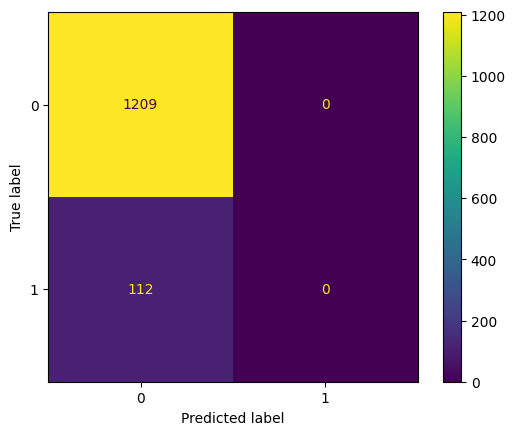

In [38]:
evaluate(dummy_classifier, X_test, y_test)

### Baseline 2: RF with undefined hyperparameters

In [36]:
rf_base = RandomForestClassifier(n_estimators = 1000)
rf_base.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [90]:
rf_base = RandomForestClassifier(n_estimators = 1000, class_weight = {0:0.001, 1:0.999})
rf_base.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.001, 1: 0.999}, n_estimators=1000)

--Evaluation-- 
Accuracy: 84.10% 
Precision: 1.96% 
F1 Score: 1.87%


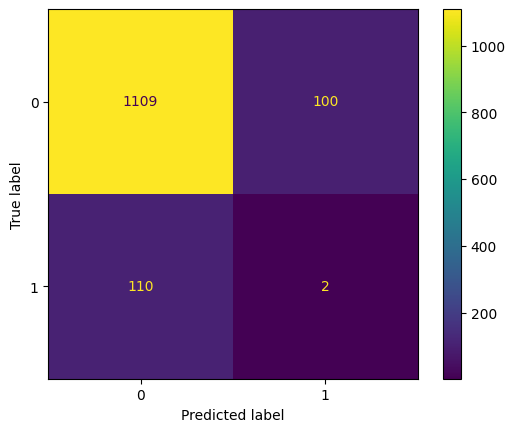

In [91]:
evaluate(rf_base, X_test, y_test)

# Hyperparameter Tuning

### Grid Search with Cross Validation for Class Weights

In [41]:
weights = np.linspace(0.0,0.99,200)
grid_params = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [43]:
rf = RandomForestClassifier(n_estimators = 1000)
rf_grid_weights = GridSearchCV(estimator = rf, param_grid = grid_params,
                               scoring = 'precision', cv = 6, verbose = 3, n_jobs = -1)

In [44]:
rf_grid_weights.fit(X_train, y_train)

Fitting 6 folds for each of 200 candidates, totalling 1200 fits


GridSearchCV(cv=6, estimator=RandomForestClassifier(n_estimators=1000),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115577889,
                                           1: 0.9850753768844221},
                                          {0: 0.019899497487437186,
                                           1: 0.9801005025125629},
                                          {0: 0.024874371859296484,
                                           1: 0.9751256281407035...
                                           1: 0.8905527638190954},
                                          {0: 0.11442211055276383,
                                           1: 0.8855778894472361},
                                          {0: 0.11939698492462311,
                                           1: 0.8806030150753769},
                                          {0: 0.12437185929648241,
                                           1: 0.8756281407035176},
                                          {0: 0.1293467336683417,
                                           1: 0.8706532663316583},
                                          {0: 0.13432160804020102,
                                           1: 0.865678391959799},
                                          {0: 0.1392964824120603,
                                           1: 0.8607035175879397},
                                          {0: 0.1442713567839196,
                                           1: 0.8557286432160804}, ...]},
             scoring='precision', verbose=3)

In [51]:
rf_grid_weights.best_params_

{'class_weight': {0: 0.39798994974874374, 1: 0.6020100502512562}}

In [54]:
best_weights = rf_grid_weights.best_params_['class_weight']
best_weights_estimator = rf_grid_weights.best_estimator_

--Evaluation-- 
Accuracy: 90.46% 
Precision: 0.00% 
F1 Score: 0.00%


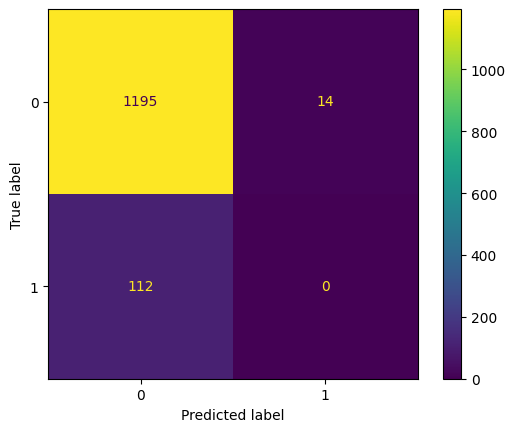

In [55]:
evaluate(best_weights_estimator, X_test, y_test)

### Random Search with Cross Validation for Other Parameters

In [72]:
n_estimators = [int(x) for x in np.linspace(200, 2000, 19)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, 10)]
max_depth.append(None)
min_samples_split = [3,5,7,9]
min_samples_leaf = [1,2,3,4]
bootstrap = [True,False]
criterion = ['gini','entropy','log_loss']
class_weight = [{0:x, 1:1.0-x} for x in weights]

In [73]:
random_params = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap,
                 'criterion': criterion,
                 'class_weight': class_weight}

In [74]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_params, scoring = 'precision',
                               n_iter = 100, cv = 3, verbose = 1, n_jobs = -1)

In [75]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\keith\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=1000),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [{0: 0.0, 1: 1.0},
                                                         {0: 0.004974874371859297,
                                                          1: 0.9950251256281407},
                                                         {0: 0.009949748743718593,
                                                          1: 0.9900502512562814},
                                                         {0: 0.014924623115577889,
                                                          1: 0.9850753768844221},
                                                         {0: 0.019899497487437186,
                                                          1: 0.98010050251...
                                                         {0: 0.1442713567839196,
                                                          1: 0.8557286432160804}, ...],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [3, 5, 7, 9],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700, 800, 900,
                                                         1000, 1100, 1200, 1300,
                                                         1400, 1500, 1600, 1700,
                                                         1800, 1900, 2000]},
                   scoring='precision', verbose=1)

In [76]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 30,
 'criterion': 'log_loss',
 'class_weight': {0: 0.4427638190954774, 1: 0.5572361809045225},
 'bootstrap': True}

--Evaluation-- 
Accuracy: 90.46% 
Precision: 0.00% 
F1 Score: 0.00%


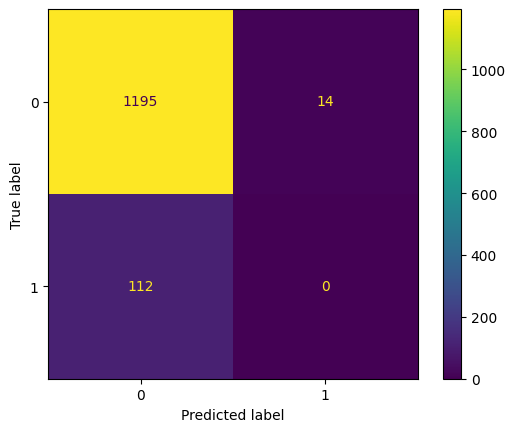

In [77]:
best_random = rf_random.best_estimator_
evaluate(rf_grid_weights, X_test, y_test)

### Grid Search with Cross Validation

In [21]:
grid_params = {'n_estimators': [1600,1700,1800],
                 'max_features': ['sqrt','auto'],
                 'max_depth': [10,20,30,None],
                 'min_samples_split': [8,9,10],
                 'min_samples_leaf': [2,3,4],
                 'bootstrap': [True]}

In [22]:
rf_grid = GridSearchCV(estimator = rf, param_grid = grid_params,
                       scoring = 'precision', cv = 6, verbose = 3, n_jobs = -1)

In [ ]:
rf_grid.fit(X_train, y_train)

In [27]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 1600}

In [29]:
best_grid = rf_grid.best_estimator_
evaluate(best_grid, X_test, y_test)

## Final Model Evaluation

#### Visualization

In [ ]:
# for i in range(3):
#     tree = rf.estimators_[i]
#     dot_data = export_graphviz(tree, feature_names = X_train.columns,
#                                filled = True, max_depth = 2, 
#                                impurity = False, proportion = True)
#     graph = graphviz.Source(dot_data)
#     display(graph)